<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.1
IPython 6.5.0

numpy 1.15.1
scipy 1.1.0
pandas 0.23.4
matplotlib 2.2.3
statsmodels 0.9.0
sklearn 0.20.0

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : e092c281d784f9aa5b8e165c554f27391d226f35


In [4]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [8]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'data'

In [9]:
def write_answer_to_file(value, filename):
    with open(filename, 'w') as fout:
            fout.writelines([str(item) + ' ' for item in value])

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [12]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [13]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                      random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [15]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [16]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='dodgerblue')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='darkorange')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [9]:
from sklearn.neighbors import KNeighborsClassifier

In [102]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1).fit(X_train, y_train)

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [103]:
cv_score = cross_val_score(knn, X_train, y_train, cv=skf, n_jobs=-1)
acc_score = accuracy_score(y_valid, knn.predict(X_valid))

In [104]:
print(f'CV score: {cv_score.mean():.3f}')
print(f'Valid score: {acc_score:.3f}')

CV score: 0.565
Valid score: 0.584


In [101]:
write_answer_to_file([round(cv_score.mean(), 3),
                     round(acc_score, 3)],
                     'answer4_1.txt')
!cat answer4_1.txt

0.565 0.584 

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=17, verbose=0, warm_start=False)

In [28]:
acc_score = accuracy_score(y_valid, forest.predict(X_valid))

In [29]:
print(f'Out-of-Bag score: {forest.oob_score_:.3f}')
print(f'Valid score: {acc_score:.3f}')

Out-of-Bag score: 0.717
Valid score: 0.731


**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [21]:
write_answer_to_file([round(forest.oob_score_, 3),
                     round(accuracy_score(y_valid, forest.predict(X_valid)), 3)],
                     'answer4_2.txt')
!cat answer4_2.txt

0.717 0.731 

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [6]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [25]:
logit = LogisticRegression(random_state=17, n_jobs=-1)
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
cv_score = cross_val_score(logit, X_train, y_train, cv=skf).mean()
acc_score = accuracy_score(y_valid, logit.predict(X_valid))

In [27]:
print(f'CV score: {cv_score:.3f}')
print(f'Valid score: {acc_score:.3f}')

Out-of-Bag score: 0.761
Valid score: 0.782


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [28]:
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(logit_c_values1, cv=skf, 
                                            multi_class='multinomial', 
                                            random_state=17, verbose=1, n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.7s finished


LogisticRegressionCV(Cs=array([  1.00000e-04,   4.64159e-04,   2.15443e-03,   1.00000e-02,
         4.64159e-02,   2.15443e-01,   1.00000e+00,   4.64159e+00,
         2.15443e+01,   1.00000e+02]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='multinomial', n_jobs=-1,
           penalty='l2', random_state=17, refit=True, scoring=None,
           solver='lbfgs', tol=0.0001, verbose=1)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [29]:
C_scores = []
for key, value in logit_grid_searcher1.scores_.items():
    C_scores.append(logit_grid_searcher1.scores_[key].mean(axis=0))
C_scores = np.asarray(C_scores).mean(axis=0)

In [30]:
C_scores

array([ 0.31822225,  0.47337913,  0.55273512,  0.65119285,  0.71297117,
        0.75137565,  0.75889437,  0.75696626,  0.74985497,  0.73999925])

In [31]:
logit_mean_cv_scores1 = C_scores

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [32]:
logit_mean_cv_scores1.max(), logit_grid_searcher1.Cs_[logit_mean_cv_scores1.argmax()]

(0.75889437054955722, 1.0)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

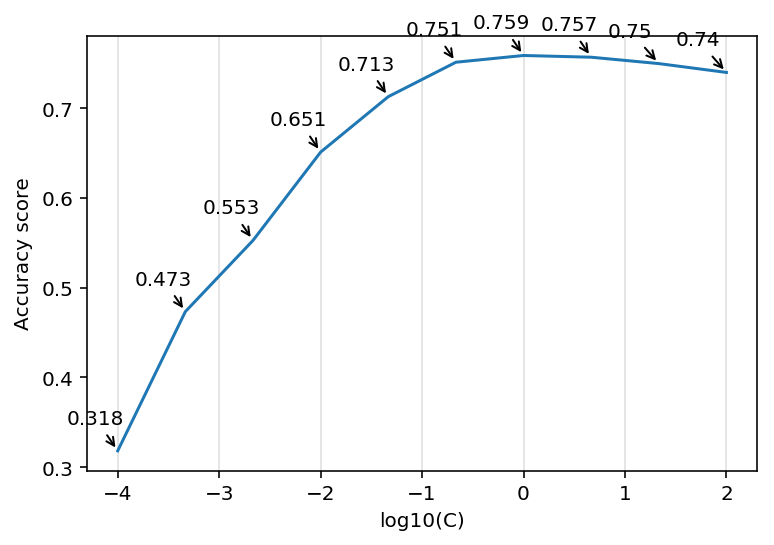

In [34]:
plt.plot(np.log10(logit_c_values1), logit_mean_cv_scores1)
plt.grid(True, alpha=.4, axis='x')
plt.xlabel('log10(C)')
plt.ylabel('Accuracy score')
for x, y in zip(np.log10(logit_c_values1), logit_mean_cv_scores1):
    plt.annotate(str(round(y, 3)), (x, y), (x-.5, y+.03), arrowprops={'arrowstyle': '->'})

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [17]:
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(logit_c_values2, cv=skf, 
                                            multi_class='multinomial', 
                                            random_state=17, verbose=1, n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.3s finished


LogisticRegressionCV(Cs=array([0.1    , 0.46316, 0.82632, 1.18947, 1.55263, 1.91579, 2.27895,
       2.64211, 3.00526, 3.36842, 3.73158, 4.09474, 4.45789, 4.82105,
       5.18421, 5.54737, 5.91053, 6.27368, 6.63684, 7.     ]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='multinomial', n_jobs=-1,
           penalty='l2', random_state=17, refit=True, scoring=None,
           solver='lbfgs', tol=0.0001, verbose=1)

In [18]:
logit_grid_searcher2.C_.mean()

0.46315789473684205

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [19]:
C_scores = []
for key, value in logit_grid_searcher2.scores_.items():
    C_scores.append(logit_grid_searcher2.scores_[key].mean(axis=0))
C_scores = np.asarray(C_scores).mean(axis=0)
C_scores

array([0.7354267 , 0.75889304, 0.75848784, 0.75777611, 0.75818339,
       0.75798073, 0.75808257, 0.7573715 , 0.75686414, 0.75696642,
       0.75706776, 0.75666178, 0.75584927, 0.75564624, 0.75524069,
       0.75463168, 0.75463211, 0.75463214, 0.75442901, 0.75402251])

In [20]:
logit_mean_cv_scores2 = C_scores

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [21]:
logit_best_C = logit_grid_searcher2.Cs_[logit_mean_cv_scores2.argmax()]

logit_mean_cv_scores2.max(), logit_best_C

(0.7588930394168386, 0.4631578947368421)

In [22]:
logit_grid_searcher2.C_.mean()

0.46315789473684205

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

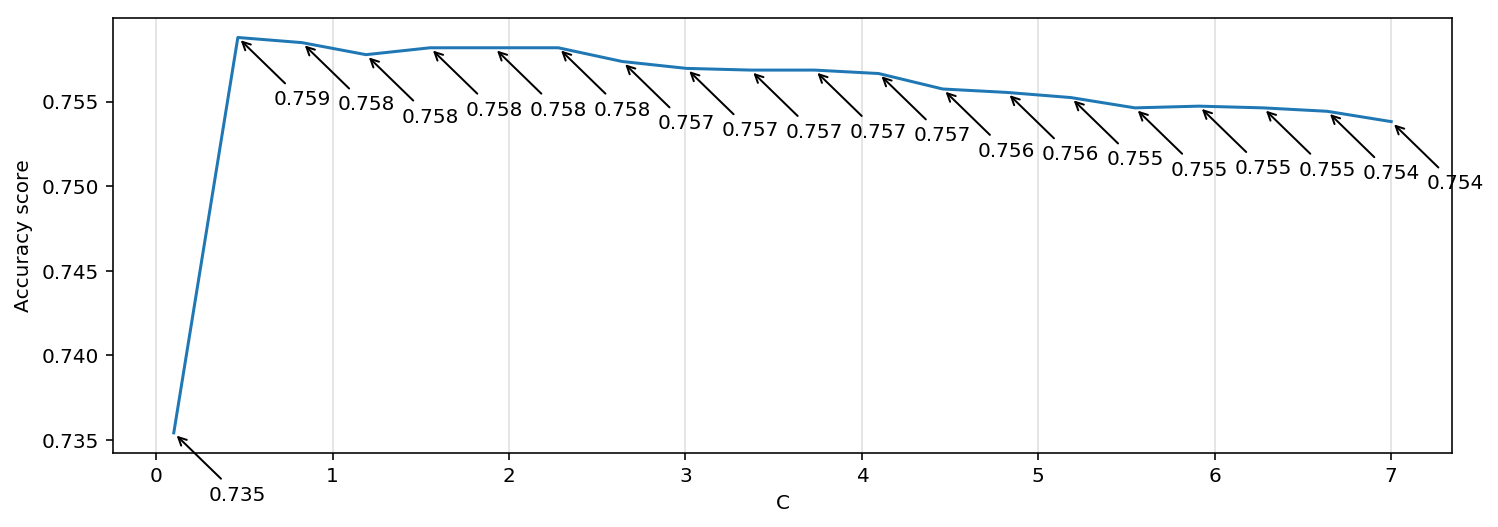

In [40]:
plt.figure(figsize=(12,4))
plt.plot(logit_c_values2, logit_mean_cv_scores2)
plt.xlabel('C')
plt.ylabel('Accuracy score')
plt.grid(True, alpha=.4, axis='x')
for x, y in zip(logit_c_values2, logit_mean_cv_scores2):
    plt.annotate(str(round(y, 3)), (x, y), (x+.2, y-.004), arrowprops={'arrowstyle': '->'});

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [107]:
logit_grid_searcher2.Cs = [best_C]

logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
cv_score = cross_val_score(logit_grid_searcher2, X_train, y_train, cv=skf, n_jobs=-1)
logit_cv_acc, cv_score.mean()

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s finished


(0.77506518132258828, 0.7587914134194883)

In [109]:
print(f'CV score: {cv_score.mean():.3f}')
print(f'Valid score: {logit_cv_acc:.3f}')

CV score: 0.759
Valid score: 0.775


In [54]:
write_answer_to_file([round(cv_score.mean(), 3),
                     round(logit_cv_acc, 3)],
                    'answer4_3.txt')
!cat answer4_3.txt

0.759 0.775 

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [55]:
from sklearn.svm import LinearSVC

In [58]:
svm = LinearSVC(random_state=17).fit(X_train, y_train)
acc_score = accuracy_score(y_valid, svm.predict(X_valid))
cv_score = cross_val_score(svm, X_train, y_train, cv=skf, n_jobs=-1)
cv_score.mean(), acc_score

(0.75279770331315266, 0.77696136525242954)

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [62]:
sorted(svm_grid_searcher1.get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__algorithm',
 'estimator__leaf_size',
 'estimator__metric',
 'estimator__metric_params',
 'estimator__n_jobs',
 'estimator__n_neighbors',
 'estimator__p',
 'estimator__weights',
 'fit_params',
 'iid',
 'n_jobs',
 'param_grid',
 'pre_dispatch',
 'refit',
 'return_train_score',
 'scoring',
 'verbose']

In [63]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1, return_train_score=True, n_jobs=-1)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 2.35 s, sys: 64.1 ms, total: 2.41 s
Wall time: 11.4 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [65]:
svm_grid_searcher1.best_score_, svm_grid_searcher1.best_params_

(0.68868116236537291, {'C': 5555.5556000000006})

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

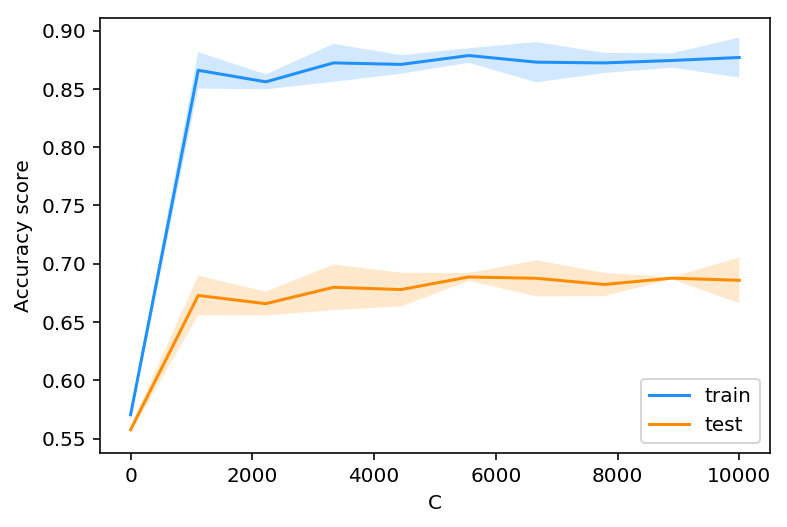

In [68]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)
plt.xlabel('C')
plt.ylabel('Accuracy score');

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [76]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2, cv=skf, return_train_score=True, n_jobs=-1)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 697 ms, sys: 113 ms, total: 810 ms
Wall time: 17.3 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [77]:
svm_grid_searcher2.best_score_, svm_grid_searcher2.best_params_

(0.76468197520829095, {'C': 0.10434482758620689})

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

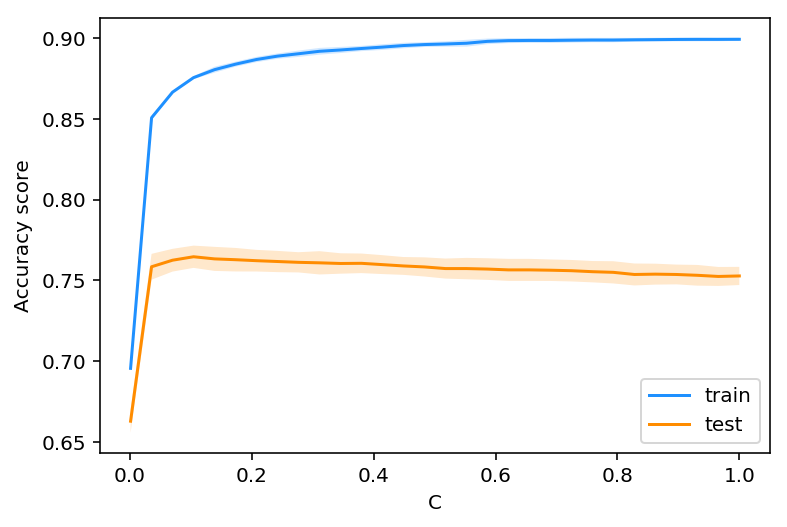

In [78]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)
plt.xlabel('C')
plt.ylabel('Accuracy score');

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [166]:
best_C = svm_grid_searcher2.best_params_['C']

In [170]:
logit = LinearSVC(C=best_C, random_state=1).fit(X_train, y_train)
print(f'{(accuracy_score(y_valid, logit.predict(X_valid))):.3f}')

0.781


**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [123]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.best_estimator_.predict(X_valid))
cv_score = cross_val_score(svm_grid_searcher2, X_train, y_train, cv=skf, n_jobs=-1)
cv_score.mean(), svm_cv_acc

(0.76468532445509807, 0.78075373311211183)

In [124]:
print(f'CV score: {cv_score.mean():.3f}')
print(f'Valid score: {svm_cv_acc:.3f}')

CV score: 0.765
Valid score: 0.781


In [125]:
write_answer_to_file([round(cv_score.mean(), 3),
                      round(svm_cv_acc, 3)],
                     'answer4_4.txt')
!cat answer4_4.txt

0.765 0.781 

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [154]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    """Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    """
    
    with open(path_to_X_pickle, 'rb') as X_pickle:
        X = pickle.load(X_pickle)
    with open(path_to_y_pickle, 'rb') as y_pickle:
        y = pickle.load(y_pickle)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size,
                                                         random_state=random_state, stratify=y)
#     print(X_train.shape, y_train.shape)
    cv_score = cross_val_score(estimator, X_train, y_train, cv=cv, n_jobs=-1)
    
    estimator.fit(X_train, y_train)
    acc_score = accuracy_score(y_valid, estimator.predict(X_valid))
    
    return cv_score.mean(), acc_score

**Убедитесь, что функция работает.**

In [155]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
                 os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.76468532445509807, 0.78075373311211183)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [128]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [157]:
%%time
estimator = svm_grid_searcher2.best_estimator_
users = 10
for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, f'X_sparse_{users}users_s{session_length}_w{window_size}.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, f'y_{users}users_s{session_length}_w{window_size}.pkl')
        print(path_to_X_pkl)
        print(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, cv=skf))

data/X_sparse_10users_s15_w10.pkl
(0.82382149552781048, 0.84048352690210948)
data/X_sparse_10users_s10_w10.pkl
(0.76468532445509807, 0.78075373311211183)
data/X_sparse_10users_s15_w7.pkl
(0.84794037698440983, 0.85432221669155473)
data/X_sparse_10users_s10_w7.pkl
(0.79701614637346518, 0.80736684917869583)
data/X_sparse_10users_s7_w7.pkl
(0.75298911148303416, 0.76173884187821472)
data/X_sparse_10users_s15_w5.pkl
(0.86800137255434695, 0.87529634898055952)
data/X_sparse_10users_s10_w5.pkl
(0.81592472053180387, 0.82456140350877194)
data/X_sparse_10users_s7_w5.pkl
(0.77405867456322597, 0.78532479848269321)
data/X_sparse_10users_s5_w5.pkl
(0.72528306503988282, 0.73624940730203892)
CPU times: user 7.86 s, sys: 662 ms, total: 8.52 s
Wall time: 14.2 s


In [148]:
with open(os.path.join(PATH_TO_DATA, f'X_sparse_10users_s15_w7.pkl'), 'rb')as f:
    X_sparse = pickle.load(f)

with open(os.path.join(PATH_TO_DATA, f'y_10users_s15_w7.pkl'), 'rb')as f:
    y_temp = pickle.load(f)


((14060, 4913), (14060,))

**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [159]:
path_to_X_sparse_10users_s15_w5 = os.path.join(PATH_TO_DATA, f'X_sparse_10users_s15_w5.pkl')
path_to_y_10users_s15_w5 = os.path.join(PATH_TO_DATA, f'y_10users_s15_w5.pkl')

In [162]:
best_window_scores = model_assessment(estimator, path_to_X_sparse_10users_s15_w5, path_to_y_10users_s15_w5, 
                 cv=skf)

In [163]:
print(f'CV scores: {best_window_scores[0]:.3f}')
print(f'Valid scores: {best_window_scores[1]:.3f}')

CV scores: 0.868
Valid scores: 0.875


In [176]:
write_answer_to_file([round(best_window_scores[0], 3),
                      round(best_window_scores[1], 3)],
                      'answer4_5.txt')
!cat answer4_5.txt

0.868 0.875 

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [165]:
%%time
estimator = svm_grid_searcher2.best_estimator_
users=150
for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA, f'X_sparse_{users}users_s{session_length}_w{window_size}.pkl')
    path_to_y_pkl = os.path.join(PATH_TO_DATA, f'y_{users}users_s{session_length}_w{window_size}.pkl')
    print(path_to_X_pkl[-11], model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, cv=skf))

data/X_sparse_150users_s5_w5.pkl
(0.40858659509908596, 0.42171606560568453)
data/X_sparse_150users_s7_w7.pkl
(0.43638649409423974, 0.45295840855673264)
data/X_sparse_150users_s10_w10.pkl
(0.46125889994279129, 0.48362769425388019)
CPU times: user 3min 23s, sys: 1.26 s, total: 3min 24s
Wall time: 5min 48s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [173]:
path_to_X_pkl = os.path.join(PATH_TO_DATA, f'X_sparse_150users.pkl')
path_to_y_pkl = os.path.join(PATH_TO_DATA, f'y_150users.pkl')

best_150users_scores = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, cv=skf)
best_150users_scores

(0.46125889994279129, 0.48362769425388019)

In [174]:
print(f'CV score: {best_150users_scores[0]:.3f}')
print(f'Validation score: {best_150users_scores[1]:.3f}')

CV score: 0.461
Validation score: 0.484


In [178]:
write_answer_to_file([round(best_150users_scores[0], 3),
                      round(best_150users_scores[1], 3)],
                      'answer4_6.txt')
!cat answer4_6.txt

0.461 0.484 

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [23]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [24]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(
    X_sparse_150users, y_150users, test_size=0.3, random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [25]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[logit_best_C], random_state=17, cv=skf, n_jobs=-1, multi_class='ovr')
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 7min 43s, sys: 14.4 s, total: 7min 57s
Wall time: 3min 21s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [30]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] = logit_cv_150users.scores_[user_id].mean()
    print('User {}, CV score: {:.4f}'.format(user_id, logit_cv_150users.scores_[user_id].mean()))

User 6, CV score: 0.9958
User 13, CV score: 0.9962
User 15, CV score: 0.9951
User 16, CV score: 0.9918
User 28, CV score: 0.9900
User 31, CV score: 0.9946
User 33, CV score: 0.9936
User 39, CV score: 0.9857
User 46, CV score: 0.9980
User 49, CV score: 0.9949
User 50, CV score: 0.9945
User 53, CV score: 0.9936
User 65, CV score: 0.9970
User 66, CV score: 0.9950
User 82, CV score: 0.9964
User 85, CV score: 0.9963
User 89, CV score: 0.9905
User 92, CV score: 0.9944
User 100, CV score: 0.9947
User 102, CV score: 0.9912
User 103, CV score: 0.9798
User 105, CV score: 0.9968
User 106, CV score: 0.9945
User 118, CV score: 0.9907
User 119, CV score: 0.9966
User 120, CV score: 0.9942
User 126, CV score: 0.9950
User 127, CV score: 0.9911
User 128, CV score: 0.9846
User 138, CV score: 0.9972
User 158, CV score: 0.9970
User 160, CV score: 0.9969
User 165, CV score: 0.9973
User 172, CV score: 0.9965
User 177, CV score: 0.9968
User 203, CV score: 0.9973
User 207, CV score: 0.9874
User 223, CV score: 

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [48]:
class_distr = np.bincount(y_train_150.astype('int'))
user_share = {}
acc_diff_vs_constant = {}

for user_id in np.unique(y_train_150):
    user_share[user_id] = class_distr[user_id] / (class_distr.sum())
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - (1 - user_share[user_id])

In [49]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
num_better_than_default

137

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [45]:
.907 * 150

136.05

In [42]:
better_than_default_share = num_better_than_default / 150

In [43]:
write_answer_to_file([round(better_than_default_share, 3)],
                    'answer4_7.txt')
!cat answer4_7.txt

0.913 

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [67]:
np.bincount(y_train_150.astype('int'))[128]

1957

In [70]:
np.array(y_150users == 128, dtype='int').sum()

2796

In [71]:
y_binary_128 = np.array(y_150users == 128, dtype='int')

In [72]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [ ]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(logit_cv_150users, )

In [ ]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.